# Setup

In [ ]:
!pip install datasets --quiet
!pip install -U bitsandbytes accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.

In [ ]:
from datasets import load_dataset

In [ ]:
import torch
from tqdm import tqdm
import time

def perplexity(model, tokenizer, text, device):
    start = time.time()
    encodings = tokenizer(text, return_tensors="pt")
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item(), time.time() - start

# Dataset

In [ ]:

# List of language codes for 30 languages (you can adjust these as needed)

languages = [
    "cy", "mt", "uz", "ps", "si", "yo", 'jv', 'ku', 'lo', 'lb',
    "bg", "he", "el", "uk", "da", "ro", "no", "id", "ms", "th",
    "en", "fr", "de", "es", "nl", "ru", "ar", "ja", "ko", "pt"
]

# Dictionary to store datasets for each language
language_datasets = {}

# Load and subset the dataset for each language
for lang in languages:
  try:
    dataset = load_dataset("oscar", f"unshuffled_deduplicated_{lang}", split="train", streaming=True)
    # Take only the first 1000 examples
    small_dataset = dataset.take(200)
    # Convert to a list
    language_datasets[lang] = list([sent_tokenize(i['text'])[0] for i in small_dataset])
  except:
    print(f"No dataset found for {lang}")

# Print the first sentence of the first 5 languages
# for lang in languages[:5]:
#     print(f"First sentence in {lang}: {language_datasets[lang][0]['text']}")

#Eval

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
def unify(txt):
  #res = [i['text'] for i in txt]
  res = txt
  return "/n /n".join(res)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
device = "cuda" if torch.cuda.is_available() else "cpu"
def eval_model(model_id, bits, text):
  if bits == 4:
      # Configure quantization
      quantization_config = BitsAndBytesConfig(
          load_in_4bit=True,
          # bnb_4bit_compute_dtype=torch.float16,
          # bnb_4bit_use_double_quant=True,
          # bnb_4bit_quant_type="nf4"
      )

      model = AutoModelForCausalLM.from_pretrained(
          model_id,
          device_map="auto",
          quantization_config=quantization_config
      )

      # Load the tokenizer
      tokenizer = AutoTokenizer.from_pretrained(model_id)
  elif bits == 8:
      # Configure quantization
      quantization_config = BitsAndBytesConfig(
          load_in_8bit=True,
          # llm_int8_threshold=6.0,
          # llm_int8_has_fp16_weight=False
      )
      model = AutoModelForCausalLM.from_pretrained(
          model_id,
          device_map="auto",
          quantization_config=quantization_config
      )
      # Load the tokenizer
      tokenizer = AutoTokenizer.from_pretrained(model_id)
  else:
    model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
  return perplexity(model, tokenizer, text, device)

In [ ]:
# test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")[0:128]
# text = "\n\n".join(test["text"])
model_id = "openai-community/gpt2-xl" #"openai-community/gpt2-large"
#model_id = "google/gemma-2b"

In [ ]:
import pandas as pd
from tqdm import tqdm
import time

res = {}
res_time = {}

for i, lang in enumerate(languages):
  print(i)
  l_res = []
  t_res = []
  text = unify(language_datasets[lang])
  for bits in [4, 8, 32]:
    ppl, elapsed = eval_model(model_id, bits, text)
    l_res.append(ppl)
    t_res.append(elapsed)
  res[lang] = l_res
  res_time[lang] = t_res
  print(lang, l_res, t_res)

0


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (14703 > 1024). Running this sequence through the model will result in indexing errors
 93%|█████████▎| 27/29 [00:12<00:00,  2.24it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (14703 > 1024). Running this sequence through the model will result in indexing errors
 93%|█████████▎| 27/29 [00:06<00:00,  3.90it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (14703 > 1024). Running this sequence through the model will result in indexing errors
 93%|█████████▎| 27/29 [00:11<00:00,  2.38it/s]


cy [88.625, 85.5625, 85.43170166015625] [12.302220106124878, 6.968930721282959, 11.72809886932373]
1


Token indices sequence length is longer than the specified maximum sequence length for this model (16611 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 31/33 [00:13<00:00,  2.33it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (16611 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 31/33 [00:07<00:00,  3.95it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (16611 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 31/33 [00:12<00:00,  2.40it/s]


mt [94.6875, 94.3125, 93.95654296875] [13.512901544570923, 7.895842552185059, 13.20968770980835]
2


Token indices sequence length is longer than the specified maximum sequence length for this model (12652 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 23/25 [00:09<00:00,  2.34it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (12652 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 23/25 [00:05<00:00,  3.86it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (12652 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 23/25 [00:09<00:00,  2.40it/s]


uz [96.5625, 94.3125, 94.08158111572266] [10.056097030639648, 5.985532999038696, 9.929668664932251]
3


Token indices sequence length is longer than the specified maximum sequence length for this model (50065 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 96/98 [00:40<00:00,  2.37it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (50065 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 96/98 [00:22<00:00,  4.17it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (50065 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 96/98 [00:40<00:00,  2.39it/s]


ps [11.03125, 10.984375, 10.94923210144043] [40.77519869804382, 23.072136878967285, 40.57439208030701]
4


Token indices sequence length is longer than the specified maximum sequence length for this model (90277 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 175/177 [01:12<00:00,  2.40it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (90277 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 175/177 [00:41<00:00,  4.21it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (90277 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 175/177 [01:12<00:00,  2.40it/s]


si [4.12109375, 4.06640625, 4.0534844398498535] [73.20771217346191, 41.725220918655396, 73.21329140663147]
5


Token indices sequence length is longer than the specified maximum sequence length for this model (5861 > 1024). Running this sequence through the model will result in indexing errors
 83%|████████▎ | 10/12 [00:04<00:00,  2.33it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (5861 > 1024). Running this sequence through the model will result in indexing errors
 83%|████████▎ | 10/12 [00:02<00:00,  3.77it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (5861 > 1024). Running this sequence through the model will result in indexing errors
 83%|████████▎ | 10/12 [00:04<00:00,  2.40it/s]


yo [13.171875, 13.40625, 13.423309326171875] [4.482581377029419, 2.6681363582611084, 4.443580627441406]
6


Token indices sequence length is longer than the specified maximum sequence length for this model (12038 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 22/24 [00:09<00:00,  2.27it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (12038 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 22/24 [00:05<00:00,  3.87it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (12038 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 22/24 [00:09<00:00,  2.37it/s]


jv [85.875, 84.25, 84.02001190185547] [9.93047046661377, 5.7110755443573, 9.66829538345337]
7


Token indices sequence length is longer than the specified maximum sequence length for this model (16681 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 31/33 [00:13<00:00,  2.30it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (16681 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 31/33 [00:07<00:00,  3.92it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (16681 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 31/33 [00:12<00:00,  2.39it/s]


ku [89.3125, 87.5625, 87.11082458496094] [13.69326114654541, 7.947968244552612, 13.334778547286987]
8


Token indices sequence length is longer than the specified maximum sequence length for this model (135356 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 263/265 [01:51<00:00,  2.36it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (135356 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 263/265 [01:02<00:00,  4.20it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (135356 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 263/265 [01:49<00:00,  2.40it/s]


lo [4.07421875, 4.03125, 4.032450199127197] [111.73543286323547, 62.82822132110596, 109.97623109817505]
9


Token indices sequence length is longer than the specified maximum sequence length for this model (11018 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:08<00:00,  2.31it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (11018 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:05<00:00,  3.86it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (11018 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:08<00:00,  2.38it/s]


lb [142.125, 143.875, 143.3560791015625] [8.900063276290894, 5.216326951980591, 8.784754753112793]
10


Token indices sequence length is longer than the specified maximum sequence length for this model (46778 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 90/92 [00:38<00:00,  2.31it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (46778 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 90/92 [00:21<00:00,  4.11it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (46778 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 90/92 [00:38<00:00,  2.36it/s]


bg [6.859375, 6.78125, 6.761010646820068] [39.13098216056824, 21.94494366645813, 38.52838206291199]
11


Token indices sequence length is longer than the specified maximum sequence length for this model (57160 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 110/112 [00:47<00:00,  2.33it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (57160 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 110/112 [00:26<00:00,  4.08it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (57160 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 110/112 [00:46<00:00,  2.36it/s]


he [6.0546875, 6.0, 5.997218608856201] [47.50119137763977, 27.05026078224182, 46.95334458351135]
12


Token indices sequence length is longer than the specified maximum sequence length for this model (58538 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 113/115 [00:48<00:00,  2.33it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (58538 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 113/115 [00:27<00:00,  4.12it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (58538 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 113/115 [00:47<00:00,  2.38it/s]


el [6.3515625, 6.16015625, 6.150542736053467] [48.80700063705444, 27.520501852035522, 47.8868989944458]
13


Token indices sequence length is longer than the specified maximum sequence length for this model (46243 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 89/91 [00:38<00:00,  2.34it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (46243 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 89/91 [00:21<00:00,  4.08it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (46243 > 1024). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 89/91 [00:37<00:00,  2.37it/s]


uk [7.11328125, 6.94921875, 6.939302444458008] [38.29935169219971, 21.910441160202026, 37.92556118965149]
14


Token indices sequence length is longer than the specified maximum sequence length for this model (9654 > 1024). Running this sequence through the model will result in indexing errors
 89%|████████▉ | 17/19 [00:07<00:00,  2.32it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (9654 > 1024). Running this sequence through the model will result in indexing errors
 89%|████████▉ | 17/19 [00:04<00:00,  3.78it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (9654 > 1024). Running this sequence through the model will result in indexing errors
 89%|████████▉ | 17/19 [00:07<00:00,  2.41it/s]


da [86.25, 82.9375, 82.64029693603516] [7.579326629638672, 4.533007621765137, 7.4630677700042725]
15


Token indices sequence length is longer than the specified maximum sequence length for this model (24066 > 1024). Running this sequence through the model will result in indexing errors
 96%|█████████▌| 46/48 [00:20<00:00,  2.26it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (24066 > 1024). Running this sequence through the model will result in indexing errors
 96%|█████████▌| 46/48 [00:11<00:00,  3.96it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (24066 > 1024). Running this sequence through the model will result in indexing errors
 96%|█████████▌| 46/48 [00:19<00:00,  2.38it/s]


ro [65.625, 63.09375, 63.02000427246094] [20.519445180892944, 11.66932201385498, 19.589930057525635]
16


Token indices sequence length is longer than the specified maximum sequence length for this model (11138 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:08<00:00,  2.30it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (11138 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:05<00:00,  3.85it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (11138 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:08<00:00,  2.39it/s]


no [54.8125, 52.90625, 52.77983856201172] [8.958187580108643, 5.2259297370910645, 8.770564794540405]
17


Token indices sequence length is longer than the specified maximum sequence length for this model (12225 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 22/24 [00:09<00:00,  2.30it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (12225 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 22/24 [00:05<00:00,  3.85it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (12225 > 1024). Running this sequence through the model will result in indexing errors
 92%|█████████▏| 22/24 [00:09<00:00,  2.37it/s]


id [86.5625, 82.3125, 82.1574478149414] [9.833499431610107, 5.743750810623169, 9.688823461532593]
18


Token indices sequence length is longer than the specified maximum sequence length for this model (10064 > 1024). Running this sequence through the model will result in indexing errors
 90%|█████████ | 18/20 [00:07<00:00,  2.32it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (10064 > 1024). Running this sequence through the model will result in indexing errors
 90%|█████████ | 18/20 [00:04<00:00,  3.83it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (10064 > 1024). Running this sequence through the model will result in indexing errors
 90%|█████████ | 18/20 [00:07<00:00,  2.39it/s]


ms [70.125, 66.625, 66.58483123779297] [8.006774425506592, 4.723885774612427, 7.896905899047852]
19


Token indices sequence length is longer than the specified maximum sequence length for this model (351538 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 685/687 [04:53<00:00,  2.34it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (351538 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 685/687 [02:45<00:00,  4.14it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (351538 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 685/687 [04:44<00:00,  2.41it/s]


th [3.759765625, 3.6796875, 3.6754767894744873] [294.0465543270111, 166.10362935066223, 285.58312797546387]
20


Token indices sequence length is longer than the specified maximum sequence length for this model (11203 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:08<00:00,  2.32it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (11203 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:05<00:00,  3.76it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (11203 > 1024). Running this sequence through the model will result in indexing errors
 91%|█████████ | 20/22 [00:08<00:00,  2.38it/s]


en [12.4921875, 12.1796875, 12.172591209411621] [8.893889904022217, 5.362150192260742, 8.81874680519104]
21


Token indices sequence length is longer than the specified maximum sequence length for this model (16984 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 32/34 [00:14<00:00,  2.24it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (16984 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 32/34 [00:08<00:00,  3.88it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (16984 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 32/34 [00:13<00:00,  2.38it/s]


fr [27.78125, 26.65625, 26.590496063232422] [14.477498769760132, 8.301735877990723, 13.698308944702148]
22


Token indices sequence length is longer than the specified maximum sequence length for this model (19453 > 1024). Running this sequence through the model will result in indexing errors
 95%|█████████▍| 36/38 [00:15<00:00,  2.30it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (19453 > 1024). Running this sequence through the model will result in indexing errors
 95%|█████████▍| 36/38 [00:09<00:00,  3.91it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (19453 > 1024). Running this sequence through the model will result in indexing errors
 95%|█████████▍| 36/38 [00:15<00:00,  2.38it/s]


de [19.015625, 18.5, 18.460994720458984] [15.965250492095947, 9.251261234283447, 15.574395656585693]
23


Token indices sequence length is longer than the specified maximum sequence length for this model (14070 > 1024). Running this sequence through the model will result in indexing errors
 93%|█████████▎| 26/28 [00:11<00:00,  2.29it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (14070 > 1024). Running this sequence through the model will result in indexing errors
 93%|█████████▎| 26/28 [00:06<00:00,  3.85it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (14070 > 1024). Running this sequence through the model will result in indexing errors
 93%|█████████▎| 26/28 [00:10<00:00,  2.39it/s]


es [30.75, 29.34375, 29.30582046508789] [11.584427833557129, 6.798824787139893, 11.183876037597656]
24


Token indices sequence length is longer than the specified maximum sequence length for this model (9776 > 1024). Running this sequence through the model will result in indexing errors
 90%|█████████ | 18/20 [00:07<00:00,  2.35it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (9776 > 1024). Running this sequence through the model will result in indexing errors
 90%|█████████ | 18/20 [00:04<00:00,  3.76it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (9776 > 1024). Running this sequence through the model will result in indexing errors
 90%|█████████ | 18/20 [00:07<00:00,  2.38it/s]


nl [63.84375, 60.4375, 60.427268981933594] [7.835252523422241, 4.818404912948608, 7.8264429569244385]
25


Token indices sequence length is longer than the specified maximum sequence length for this model (70028 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▊| 135/137 [00:56<00:00,  2.38it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (70028 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▊| 135/137 [00:32<00:00,  4.13it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (70028 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▊| 135/137 [00:56<00:00,  2.38it/s]


ru [5.12890625, 5.0, 4.990022659301758] [57.002891063690186, 32.78562068939209, 57.13420248031616]
26


Token indices sequence length is longer than the specified maximum sequence length for this model (117407 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 228/230 [01:37<00:00,  2.34it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (117407 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 228/230 [00:55<00:00,  4.14it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (117407 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 228/230 [01:34<00:00,  2.40it/s]


ar [6.30859375, 6.2109375, 6.2032694816589355] [97.63294267654419, 55.327643156051636, 95.34606599807739]
27


Token indices sequence length is longer than the specified maximum sequence length for this model (204608 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 398/400 [02:50<00:00,  2.34it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (204608 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 398/400 [01:37<00:00,  4.09it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (204608 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 398/400 [02:46<00:00,  2.40it/s]


ja [10.796875, 10.546875, 10.527917861938477] [170.63420581817627, 97.63144946098328, 166.68191981315613]
28


Token indices sequence length is longer than the specified maximum sequence length for this model (82485 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 160/162 [01:09<00:00,  2.31it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (82485 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 160/162 [00:38<00:00,  4.14it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (82485 > 1024). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 160/162 [01:06<00:00,  2.39it/s]


ko [4.26953125, 4.20703125, 4.203646183013916] [69.41710209846497, 38.754119634628296, 67.23477220535278]
29


Token indices sequence length is longer than the specified maximum sequence length for this model (17481 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 33/35 [00:13<00:00,  2.36it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (17481 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 33/35 [00:08<00:00,  3.91it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (17481 > 1024). Running this sequence through the model will result in indexing errors
 94%|█████████▍| 33/35 [00:13<00:00,  2.37it/s]


pt [38.03125, 36.4375, 36.352230072021484] [14.2031090259552, 8.478782653808594, 14.191944122314453]


In [ ]:
df = pd.DataFrame.from_dict(res, orient='index', columns=['4 bits', '8 bits', '32 bits'])
df.to_csv('evaluation_results_xl.csv', index_label='Language')


df = pd.DataFrame.from_dict(res_time, orient='index', columns=['4 bits', '8 bits', '32 bits'])
df.to_csv('time_elapsed_xl.csv', index_label='Language')
print("Results saved to time_elapsed.csv")

Results saved to time_elapsed.csv


In [ ]:
df = pd.DataFrame.from_dict(res, orient='index', columns=['4 bits', '8 bits', '32 bits'])
df.to_csv('/content/drive/MyDrive/Colab Notebooks/quant_degrade/large/evaluation_results_xl.csv', index_label='Language')


df = pd.DataFrame.from_dict(res_time, orient='index', columns=['4 bits', '8 bits', '32 bits'])
df.to_csv('/content/drive/MyDrive/Colab Notebooks/quant_degrade/large/time_xl.csv', index_label='Language')
print("Results saved to time_elapsed.csv")

Results saved to time_elapsed.csv


https://w3techs.com/technologies/overview/content_language
https://arxiv.org/pdf/2309.09400

# analysis

In [ ]:
#path = '/content/drive/MyDrive/Colab Notebooks/quant_degrade/large/evaluation_results_large.csv'
path = '/content/evaluation_results_large2.csv'
#path = '/content/evaluation_results_xl (1).csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Load the data (assuming the DataFrame is already loaded as quantization_results)
quantization_results = pd.read_csv(path)
# Add the Internet Fraction data #https://commoncrawl.github.io/cc-crawl-statistics/plots/languages.html
language_internet_fraction = {
    # 'en': 43.7909,    'fr': 4.2211,    'de': 5.289,    'es': 4.5593,    'it': 2.6077,    'pt': 2.1237,    'nl': 1.8216,    'ru': 6.1035,    'zh': 5.1358,
    # 'ar': 0.6881,    'ja': 4.798,    'ko': 0.7032,    'tr': 1.28,    'sv': 0.6803,    'pl': 1.7963,
    # 'cs': 1.0256,    'fi': 0.3472,    'da': 0.4487,    'no': 0.3036,    'he': 0.2344,    'hu': 0.5646,    'el': 0.5633,    'ro': 0.5781,
    # 'bg': 0.2998,    'uk': 0.5832,    'vi': 1.0133,    'th': 0.4275,    'id': 1.0426,    'ms': 0.0735,    'hi': 0.194,    'sq': 0.0542,
    # 'sk': 0.4022,    'sl': 0.1613,    'lt': 0.155,    'lv': 0.0882,    'et': 0.1285,    'sr': 0.2293,    'hr': 0.2118,    'bs': 0.0551,
    # 'mk': 0.0393,    'mt': 0.0044,    'is': 0.0387,    'ga': 0.0069,    'af': 0.0052,    'sw': 0.0030,    'am': 0.0029,    'hy': 0.0355,
    # 'az': 0.0129,    'ka': 0.0403,    'ky': 0.0084,    'kk': 0.0280,    'uz': 0.0069,    'mn': 0.0157,    'tg': 0.0021,    'ta': 0.0197,
    # 'te': 0.0183,    'ml': 0.0246,    'kn': 0.0159,    'gu': 0.0126,    'mr': 0.0283,    'pa': 0.0065,    'ur': 0.0038,    'bn': 0.0473,
    # 'my': 0.0129,    'km': 0.0112,    'lo': 0.0037,    'si': 0.0022,    'ne': 0.0504,    'as': 0.00001,    'or': 0.0060,    'fa': 0.7665,
    # 'ps': 0.0020,    'sd': 0.0001,    'ku': 0.0061,    'ckb': 0.00001,    'yo': 0.0006, 'cy': 0.01,
    "cy": 0.0100,
    "mt": 0.0044,
    "uz": 0.0240, # Uzbek (extracted from a broader dataset, typically low)
    "ps": 0.0035, # Pashto
    "si": 0.0087, # Sinhala
    "yo": 0.0009, # Yoruba
    "jv": 0.0020, # Javanese
    "ku": 0.0061, # Kurdish
    "lo": 0.0037, # Lao
    "lb": 0.0035, # Luxembourgish
    "bg": 0.2998, # Bulgarian
    "he": 0.2344, # Hebrew
    "el": 0.5633, # Greek
    "uk": 0.5832, # Ukrainian
    "da": 0.4487, # Danish
    "ro": 0.5781, # Romanian
    "no": 0.3036, # Norwegian
    "id": 1.0426, # Indonesian
    "ms": 0.0735, # Malay
    "th": 0.4275, # Thai
    "en": 43.7909, # English
    "fr": 4.2211, # French
    "de": 5.2890, # German
    "es": 4.5593, # Spanish
    "nl": 1.8216, # Dutch
    "ru": 6.1035, # Russian
    "ar": 0.6881, # Arabic
    "ja": 4.7980, # Japanese
    "ko": 0.7032, # Korean
    "pt": 2.1237  # Portuguese
}

language_resourcedness = {
#uk, bg -- MR -> LR, ko, ar -- HR -> MR
    'cy': 'LR', 'mt': 'LR', 'uz': 'LR', 'ps': 'LR', 'si': 'LR', 'yo': 'LR', 'jv': 'LR', 'ku': 'LR', 'lo': 'LR', 'lb': 'LR',
    'bg': 'MR', 'he': 'MR', 'el': 'MR', 'uk': 'MR', 'da': 'MR', 'ro': 'MR', 'no': 'MR', 'id': 'MR', 'ms': 'MR', 'th': 'MR',
    'en': 'HR', 'fr': 'HR', 'de': 'HR', 'es': 'HR', 'nl': 'HR', 'ru': 'HR', 'ar': 'HR', 'ja': 'HR', 'ko': 'HR', 'pt': 'HR'

    # 'en': 'HR', 'fr': 'HR', 'de': 'HR', 'es': 'HR', 'zh': 'HR', 'ru': 'HR', 'ja': 'HR',
    # 'it': 'MR', 'pt': 'MR', 'nl': 'MR', 'tr': 'MR', 'sv': 'MR', 'pl': 'MR', 'cs': 'MR', 'id': 'MR', 'uk': 'MR',
    # 'ar': 'LR', 'ko': 'LR', 'fi': 'LR', 'da': 'LR', 'no': 'LR', 'he': 'LR', 'hu': 'LR', 'el': 'LR', 'ro': 'LR',
    # 'bg': 'LR', 'vi': 'LR', 'th': 'LR', 'ms': 'LR', 'hi': 'LR'
    # "en": "HR",    "fr": "HR",    "de": "HR",    "es": "HR",
    # "it": "HR",    "pt": "HR",    "nl": "HR",    "ru": "HR",    "zh": "HR",    "ar": "HR",    "ja": "HR",    "ko": "HR",
    # "tr": "HR",    "sv": "HR",    "pl": "HR",    "cs": "HR",    "fi": "HR",    "da": "MR",    "no": "LR",    "he": "MR",
    # "hu": "HR",    "el": "MR",    "ro": "MR",    "bg": "MR",    "uk": "MR",    "vi": "HR",    "th": "MR",    "id": "MR",
    # "ms": "MR",    "hi": "HR"
    }
color_map = {'HR': 'blue', 'MR': 'orange', 'LR': 'red'}

quantization_results['Internet Fraction'] = quantization_results['Language'].map(language_internet_fraction)
#print(quantization_results)
quantization_results['Log Dataset Fraction'] = np.log(quantization_results['Internet Fraction'])

# Calculate the fraction of 32-bit over 4-bit perplexity
quantization_results['Fraction 4-32'] = quantization_results['4 bits'] / quantization_results['32 bits']
quantization_results['Fraction 8-32'] = quantization_results['8 bits'] / quantization_results['32 bits']
quantization_results['Fraction 32-4'] = quantization_results['32 bits'] / quantization_results['4 bits']
quantization_results['Fraction 8-4'] = quantization_results['8 bits'] / quantization_results['4 bits']
quantization_results['degradation 32-4'] = (1 - quantization_results['32 bits'] / quantization_results['4 bits'])
quantization_results['Log degradation 32-4'] = np.log(1 - quantization_results['32 bits'] / quantization_results['4 bits'])
quantization_results['Log degradation 32-8'] = np.log(1 - quantization_results['32 bits'] / quantization_results['8 bits'])
quantization_results['Log degradation 8-4'] = np.log(1 - quantization_results['8 bits'] / quantization_results['4 bits'])


#quantization_results['Fraction 32-4'] = quantization_results['32 bits'] / quantization_results['4 bits']
# Calculate the fraction of 32-bit over 4-bit perplexity, scaled by 100
quantization_results['Log Fraction 4-32'] = np.log(quantization_results['Fraction 4-32'])
quantization_results['Log Fraction 8-32'] = np.log(quantization_results['Fraction 8-32'])
quantization_results['Diff 4-32'] = quantization_results['4 bits'] - quantization_results['32 bits']
quantization_results['loss 32-4'] = (quantization_results['4 bits'] - quantization_results['32 bits'])
quantization_results['log loss 32-4'] = np.log(quantization_results['loss 32-4'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Linear Fit Coefficients: [ 0.0560038  -0.06742734]
Linear Fit R-squared: 0.8728065829885403


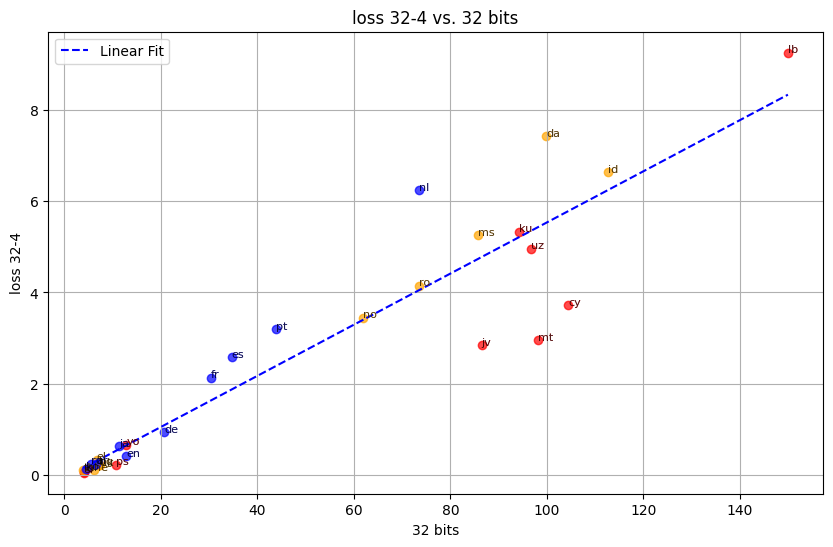

Linear Fit Coefficients: [ 0.00523418 -3.46717453]
Linear Fit R-squared: 0.23762886403393546


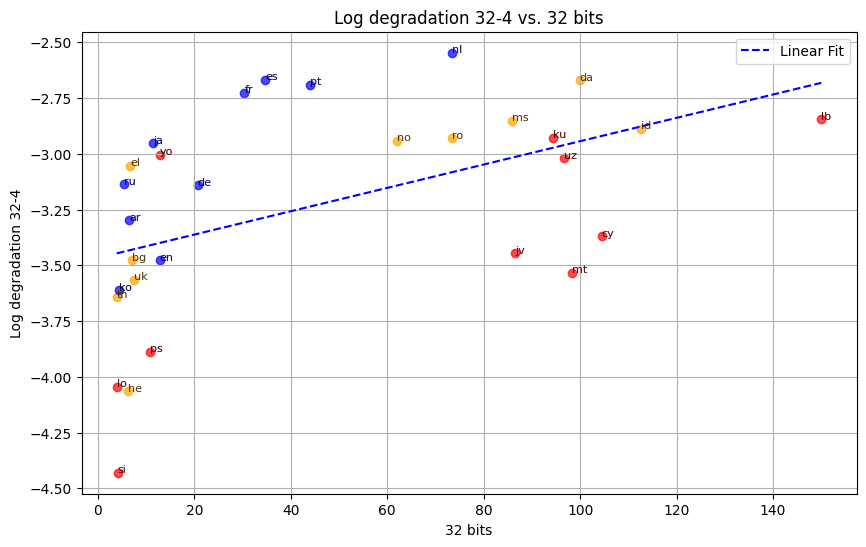

Linear Fit Coefficients: [ 1.0530068  -0.02961988]
Linear Fit R-squared: 0.9995785184611943


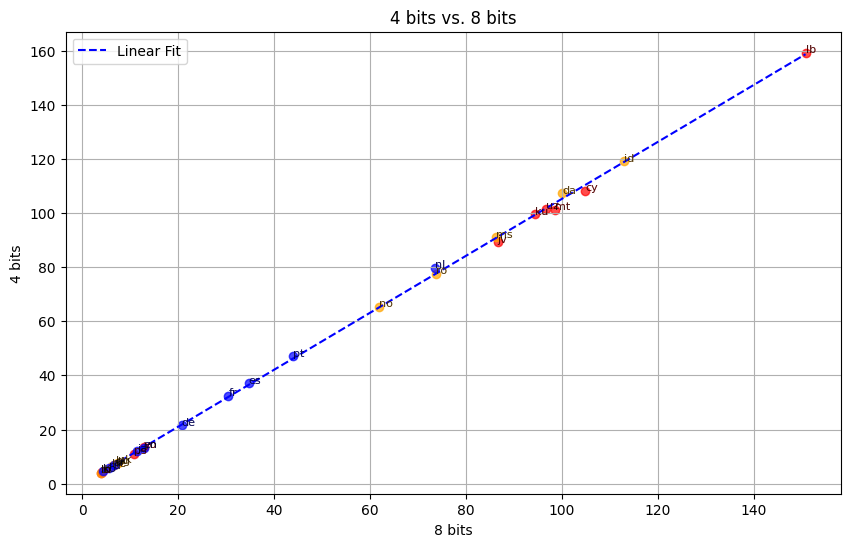

Quadratic Fit Coefficients: [-7.56736815e-05  1.72019499e-03  4.74091195e-02]
Quadratic Fit R-squared: 0.11554834656476043
Linear Fit Coefficients: [0.00203438 0.04708973]
Linear Fit R-squared: 0.11443748058043635


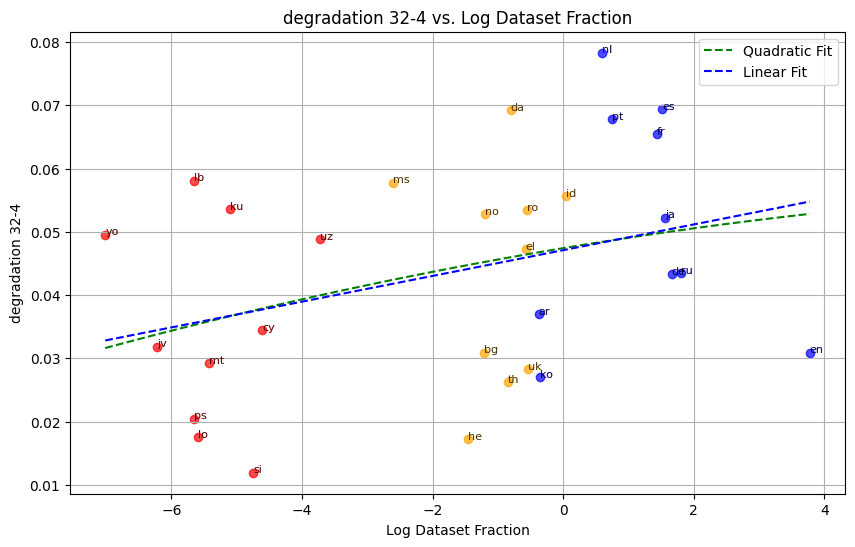

Quadratic Fit Coefficients: [-8.81879561e-04  5.52507215e-02 -3.15114460e+00]
Quadratic Fit R-squared: 0.14117846280560176
Linear Fit Coefficients: [ 0.05891209 -3.15486668]
Linear Fit R-squared: 0.14095686692769216


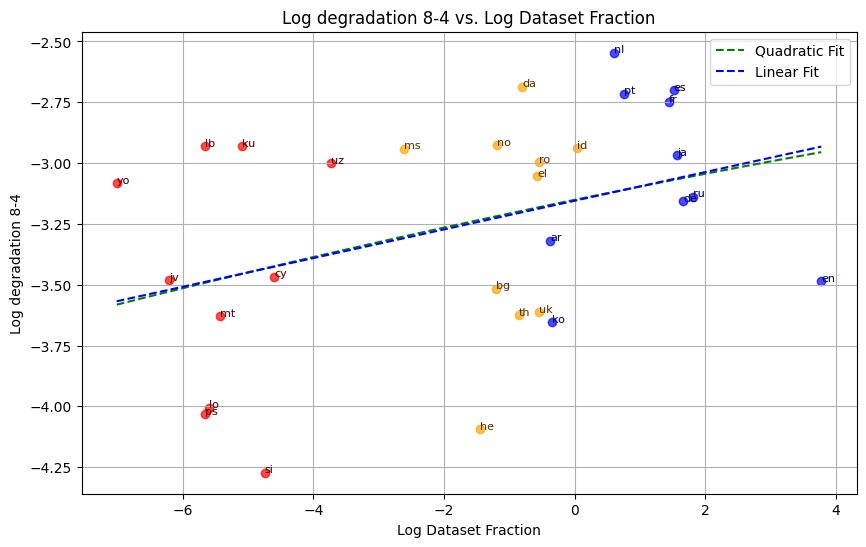

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_and_fit(dataframe, x_column, y_column, include_quad=True, include_lin=True):
    # Linear Fit
    linear_coeffs = np.polyfit(dataframe[x_column], dataframe[y_column], 1)
    linear_fit = np.poly1d(linear_coeffs)
    x_values = np.linspace(dataframe[x_column].min(), dataframe[x_column].max(), 100)
    linear_values = linear_fit(x_values)

    # Quadratic Fit
    quadratic_coeffs = np.polyfit(dataframe[x_column], dataframe[y_column], 2)
    quadratic_fit = np.poly1d(quadratic_coeffs)
    quadratic_values = quadratic_fit(x_values)

    # Plotting
    plt.figure(figsize=(10, 6))
    # Plotting points with colors based on resourcedness
    for i, row in dataframe.iterrows():
        color = color_map.get(language_resourcedness.get(row['Language'], 'LR'))  # Default to LR if not found
        plt.scatter(row[x_column], row[y_column], color=color, alpha=0.7)
        plt.annotate(row['Language'], (row[x_column], row[y_column]), fontsize=8, alpha=0.7, color=color)


    # Plot the fits
    if include_quad:
        plt.plot(x_values, quadratic_values, color='green', linestyle='--', label='Quadratic Fit')

        quadratic_residuals = quantization_results[y_column] - quadratic_fit(quantization_results[x_column])
        quadratic_ss_res = np.sum(quadratic_residuals**2)
        quadratic_ss_tot = np.sum((quantization_results[y_column] - np.mean(quantization_results[y_column]))**2)
        quadratic_r_squared = 1 - (quadratic_ss_res / quadratic_ss_tot)
        print("Quadratic Fit Coefficients:", quadratic_coeffs)
        print("Quadratic Fit R-squared:", quadratic_r_squared)
    if include_lin:
        plt.plot(x_values, linear_values, color='blue', linestyle='--', label='Linear Fit')
        # Calculate R-squared for Linear Fit
        linear_residuals = quantization_results[y_column] - linear_fit(quantization_results[x_column])
        dataframe['linear residuals'] = linear_residuals
        linear_ss_res = np.sum(linear_residuals**2)
        linear_ss_tot = np.sum((quantization_results[y_column] - np.mean(quantization_results[y_column]))**2)
        linear_r_squared = 1 - (linear_ss_res / linear_ss_tot)
        print("Linear Fit Coefficients:", linear_coeffs)
        print("Linear Fit R-squared:", linear_r_squared)
        #print("Quadratic Fit Coefficients:", quadratic_coeffs)

    # Annotate each point with the language code
    for i, row in dataframe.iterrows():
        plt.annotate(row['Language'], (row[x_column], row[y_column]), fontsize=8, alpha=0.7)

    plt.title(f'{y_column} vs. {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with the data already loaded as 'quantization_results':
plot_and_fit(quantization_results, '32 bits', 'loss 32-4', include_quad=False)
plot_and_fit(quantization_results, '32 bits', 'Log degradation 32-4', include_quad=False)

plot_and_fit(quantization_results, '8 bits', '4 bits', include_quad=False)
plot_and_fit(quantization_results, 'Log Dataset Fraction', 'degradation 32-4',  include_lin=True)
plot_and_fit(quantization_results, 'Log Dataset Fraction', 'Log degradation 8-4',  include_lin=True)

In [ ]:
quantization_results.columns

Index(['Language', '4 bits', '8 bits', '32 bits', 'Internet Fraction',
       'Log Dataset Fraction', 'Fraction 4-32', 'Fraction 8-32',
       'Fraction 32-4', 'Fraction 8-4', 'degradation 32-4',
       'Log degradation 32-4', 'Log degradation 32-8', 'Log degradation 8-4',
       'Log Fraction 4-32', 'Log Fraction 8-32', 'Diff 4-32', 'loss 32-4',
       'log loss 32-4', 'linear residuals'],
      dtype='object')

Mean values for loss 32-4:
HR: 1.6754
MR: 2.7916
LR: 3.0082


<ipython-input-28-51a5c2435d69>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})


Pairwise Paired T-Tests:
HR vs MR: t-statistic = -0.9993, p-value = 0.3309, mean difference = -1.1162, standard deviations: 1.9422, 2.9504
HR vs LR: t-statistic = -1.1880, p-value = 0.2503, mean difference = -1.3329, standard deviations: 1.9422, 2.9692
MR vs LR: t-statistic = -0.1637, p-value = 0.8718, mean difference = -0.2167, standard deviations: 2.9504, 2.9692


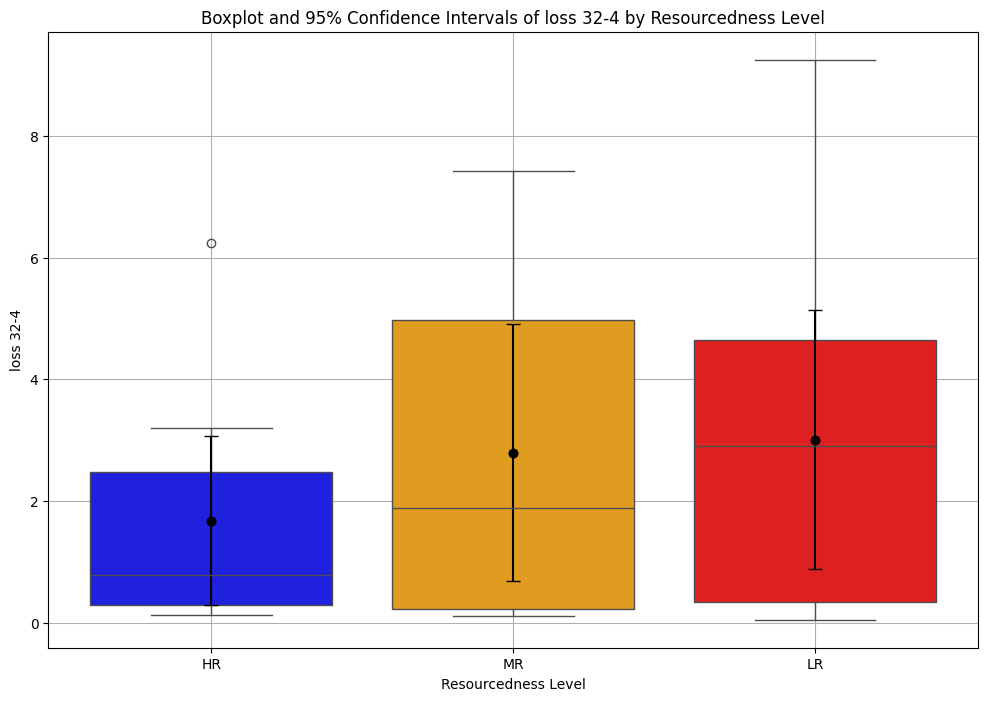

Mean values for log loss 32-4:
HR: -0.1592
MR: -0.0359
LR: 0.1417


<ipython-input-28-51a5c2435d69>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})


Pairwise Paired T-Tests:
HR vs MR: t-statistic = -0.1748, p-value = 0.8632, mean difference = -0.1233, standard deviations: 1.2990, 1.8143
HR vs LR: t-statistic = -0.4137, p-value = 0.6840, mean difference = -0.3009, standard deviations: 1.2990, 1.8980
MR vs LR: t-statistic = -0.2138, p-value = 0.8331, mean difference = -0.1775, standard deviations: 1.8143, 1.8980


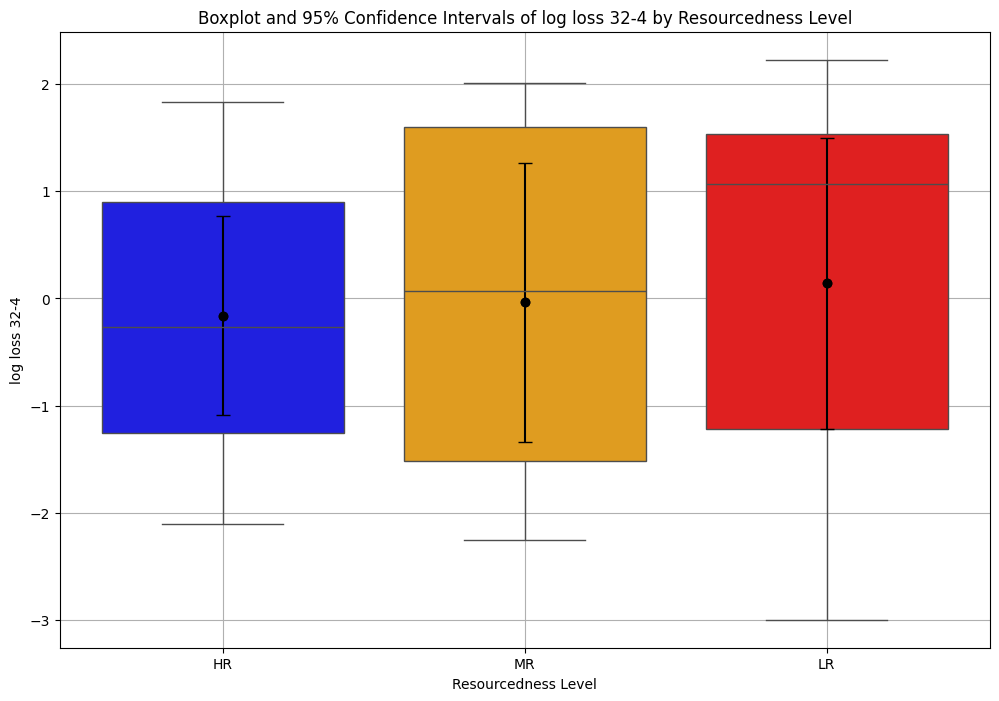

Mean values for Log Fraction 4-32:
HR: 0.0530
MR: 0.0450
LR: 0.0363


<ipython-input-28-51a5c2435d69>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})


Pairwise Paired T-Tests:
HR vs MR: t-statistic = 0.9799, p-value = 0.3401, mean difference = 0.0080, standard deviations: 0.0188, 0.0177
HR vs LR: t-statistic = 2.0907, p-value = 0.0510, mean difference = 0.0167, standard deviations: 0.0188, 0.0168
MR vs LR: t-statistic = 1.1239, p-value = 0.2758, mean difference = 0.0087, standard deviations: 0.0177, 0.0168


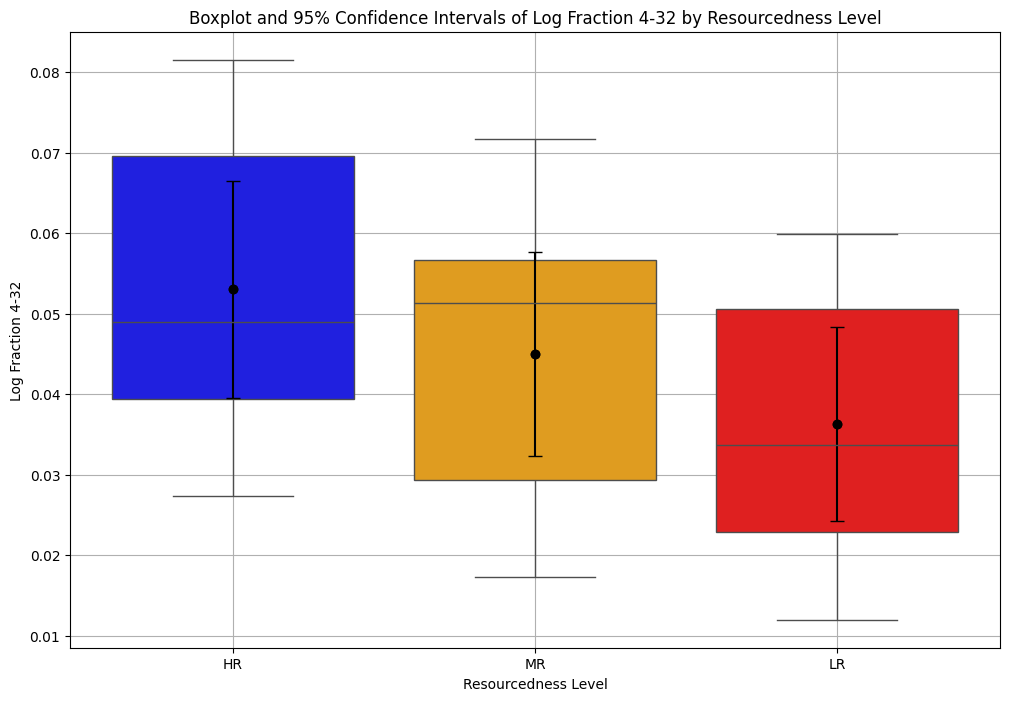

Mean values for Log degradation 32-4:
HR: -3.0248
MR: -3.2083
LR: -3.4510


<ipython-input-28-51a5c2435d69>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})


Pairwise Paired T-Tests:
HR vs MR: t-statistic = 1.0012, p-value = 0.3300, mean difference = 0.1835, standard deviations: 0.3669, 0.4486
HR vs LR: t-statistic = 2.0874, p-value = 0.0513, mean difference = 0.4262, standard deviations: 0.3669, 0.5312
MR vs LR: t-statistic = 1.1038, p-value = 0.2842, mean difference = 0.2427, standard deviations: 0.4486, 0.5312


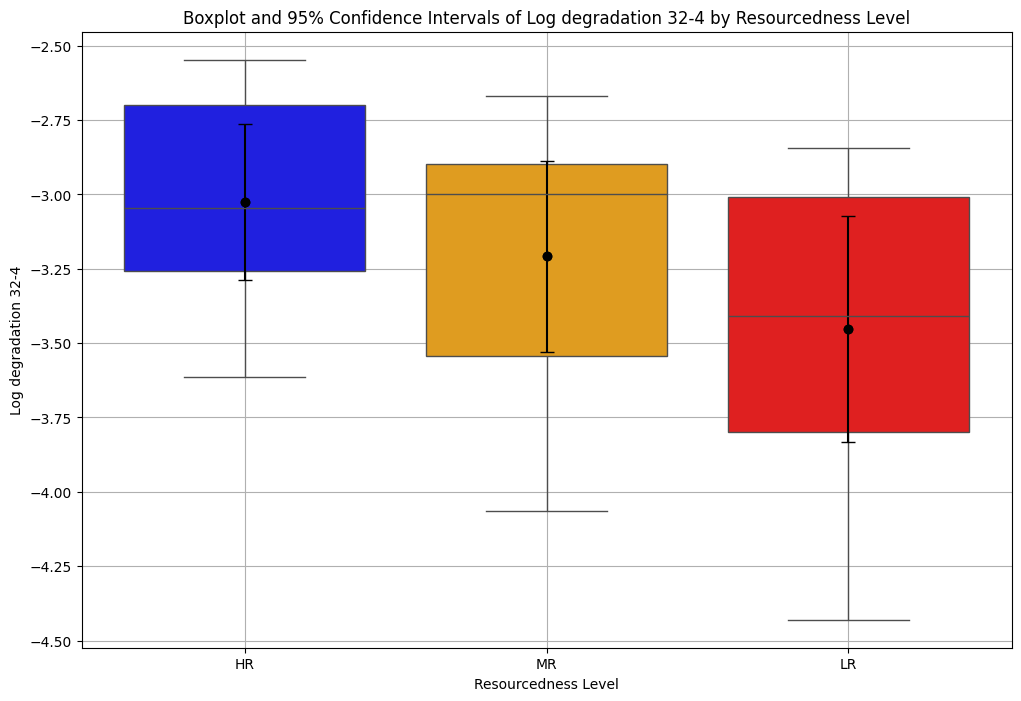

Mean values for Fraction 4-32:
HR: 1.0546
MR: 1.0462
LR: 1.0371


<ipython-input-28-51a5c2435d69>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})


Pairwise Paired T-Tests:
HR vs MR: t-statistic = 0.9822, p-value = 0.3390, mean difference = 0.0084, standard deviations: 0.0199, 0.0185
HR vs LR: t-statistic = 2.0916, p-value = 0.0509, mean difference = 0.0175, standard deviations: 0.0199, 0.0174
MR vs LR: t-statistic = 1.1263, p-value = 0.2748, mean difference = 0.0091, standard deviations: 0.0185, 0.0174


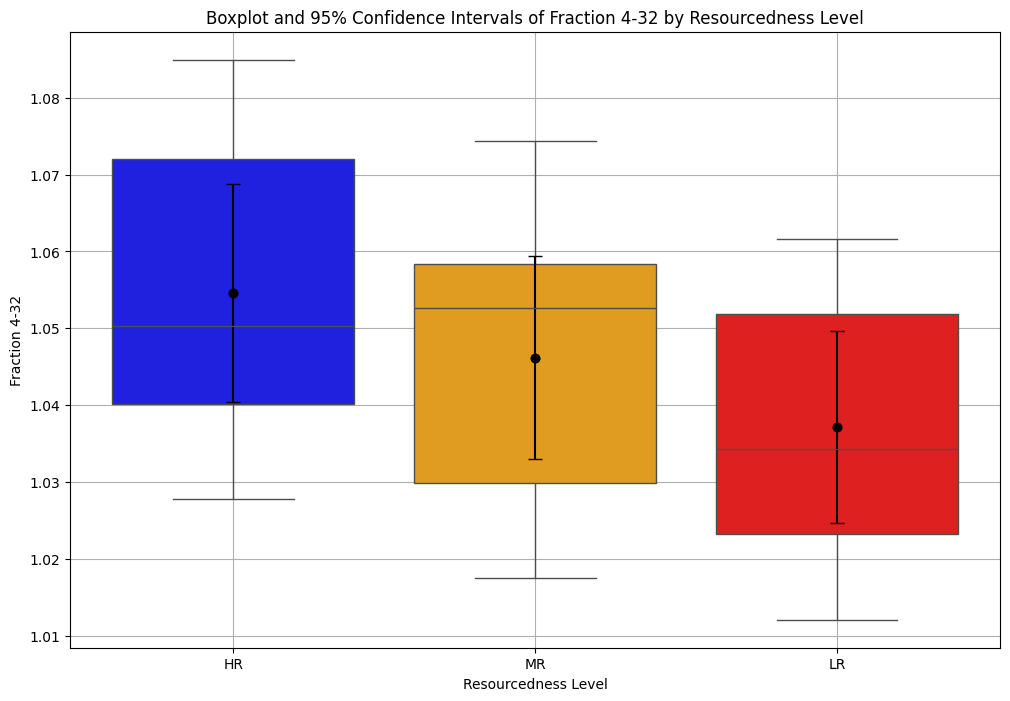

Mean values for Diff 4-32:
HR: 1.6754
MR: 2.7916
LR: 3.0082
Pairwise Paired T-Tests:
HR vs MR: t-statistic = -0.9993, p-value = 0.3309, mean difference = -1.1162, standard deviations: 1.9422, 2.9504
HR vs LR: t-statistic = -1.1880, p-value = 0.2503, mean difference = -1.3329, standard deviations: 1.9422, 2.9692

<ipython-input-28-51a5c2435d69>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})



MR vs LR: t-statistic = -0.1637, p-value = 0.8718, mean difference = -0.2167, standard deviations: 2.9504, 2.9692


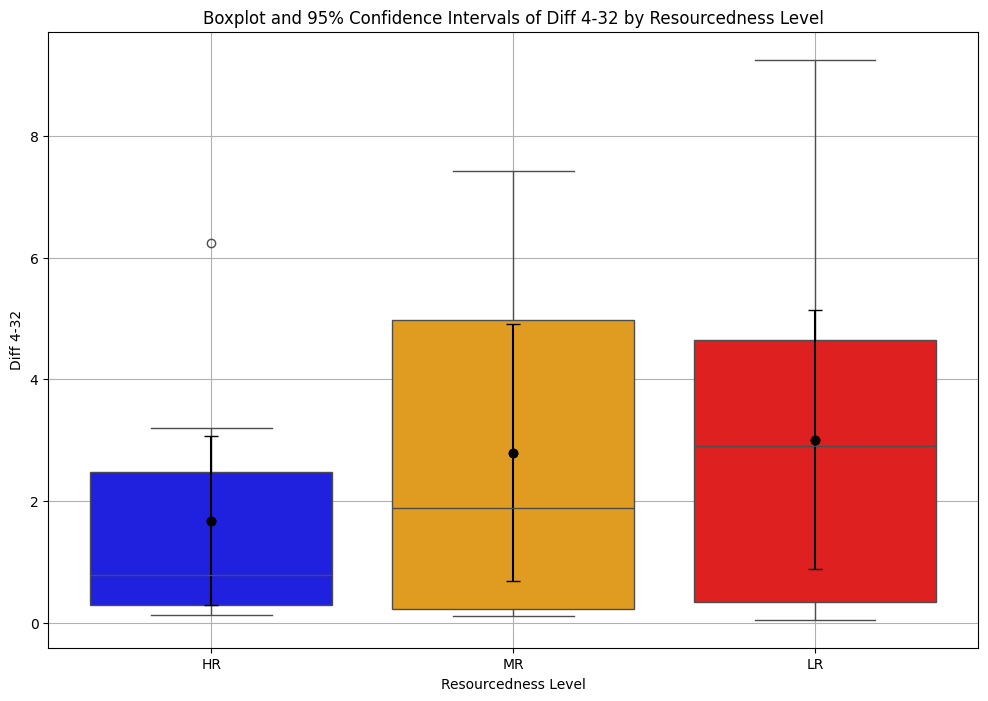

Mean values for Log Dataset Fraction:
HR: 1.2406
MR: -0.9729
LR: -5.3742
Pairwise Paired T-Tests:
HR vs MR: t-statistic = 5.0086, p-value = 0.0001, mean difference = 2.2135, standard deviations: 1.2002, 0.7160
HR vs LR: t-statistic = 13.9159, p-value = 0.0000, mean difference = 6.6148, standard deviations: 1.2002, 0.9050
MR vs LR: t-statistic = 12.0612, p-value = 0.0000, mean difference = 4.4014, standard deviations: 0.7160, 0.9050


<ipython-input-28-51a5c2435d69>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})


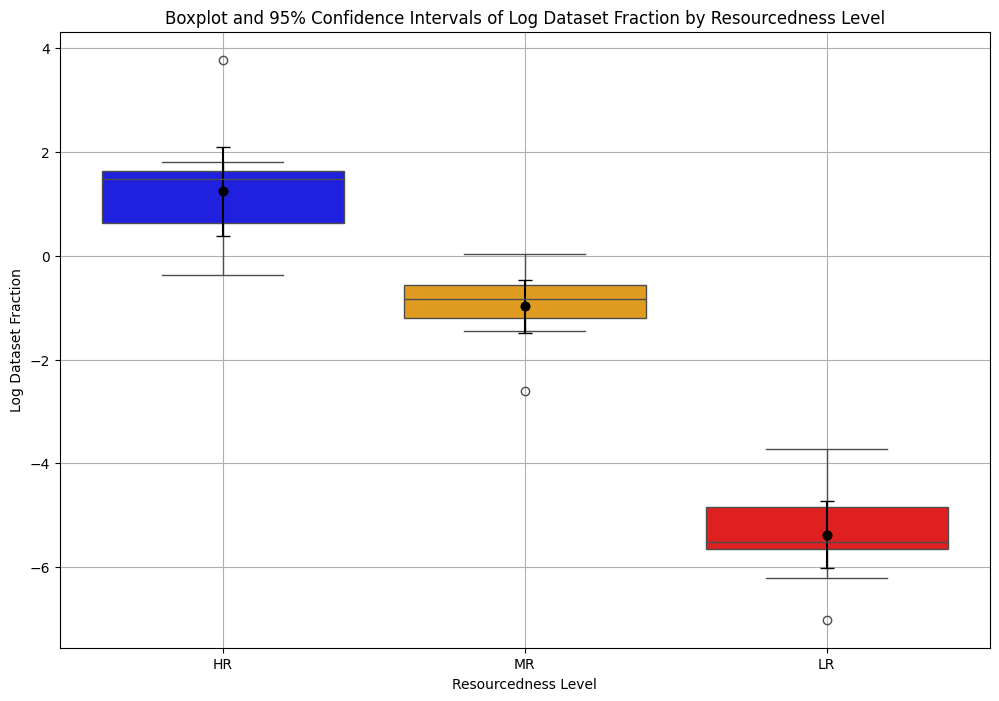

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def boxplot_with_ci(dataframe, column):
    # Create a new column in the dataframe to categorize languages into HR, MR, LR
    dataframe['Resourcedness'] = dataframe['Language'].map(language_resourcedness)

    # Drop rows with missing resourcedness labels (if any)
    dataframe = dataframe.dropna(subset=['Resourcedness'])

    # Print mean values for HR, MR, and LR
    print(f"Mean values for {column}:")
    for resourcedness_level in ['HR', 'MR', 'LR']:
        mean_value = dataframe[dataframe['Resourcedness'] == resourcedness_level][column].mean()
        print(f"{resourcedness_level}: {mean_value:.4f}")

    # Initialize the plot
    plt.figure(figsize=(12, 8))

    # Create the boxplot
    sns.boxplot(x='Resourcedness', y=column, data=dataframe, order=['HR', 'MR', 'LR'], palette={'HR': 'blue', 'MR': 'orange', 'LR': 'red'})

    # Calculate and plot 95% confidence intervals
    for resourcedness_level in ['HR', 'MR', 'LR']:
        data = dataframe[dataframe['Resourcedness'] == resourcedness_level][column]
        mean = np.mean(data)
        ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=stats.sem(data))

        # Plot the mean
        plt.scatter([resourcedness_level], [mean], color='black', zorder=5)
        # Plot the confidence interval as an error bar
        plt.errorbar(resourcedness_level, mean, yerr=[[mean-ci[0]], [ci[1]-mean]], fmt='o', color='black', capsize=5)

    # Perform pairwise paired t-tests between HR, MR, and LR
    pairs = [('HR', 'MR'), ('HR', 'LR'), ('MR', 'LR')]
    print("Pairwise Paired T-Tests:")
    for (group1, group2) in pairs:
        data1 = dataframe[dataframe['Resourcedness'] == group1][column]
        data2 = dataframe[dataframe['Resourcedness'] == group2][column]
        t_stat, p_value = stats.ttest_ind(data1, data2)
        mean_diff = np.mean(data1) - np.mean(data2)
        std1 = np.std(data1, ddof=1)
        std2 = np.std(data2, ddof=1)
        print(f"{group1} vs {group2}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}, mean difference = {mean_diff:.4f}, standard deviations: {std1:.4f}, {std2:.4f}")

    # Set plot title and labels
    plt.title(f'Boxplot and 95% Confidence Intervals of {column} by Resourcedness Level')
    plt.xlabel('Resourcedness Level')
    plt.ylabel(column)
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage with the data already loaded as 'quantization_results':
boxplot_with_ci(quantization_results, 'loss 32-4')
boxplot_with_ci(quantization_results, 'log loss 32-4')
boxplot_with_ci(quantization_results, 'Log Fraction 4-32')
boxplot_with_ci(quantization_results, 'Log degradation 32-4')
boxplot_with_ci(quantization_results, 'Fraction 4-32')
boxplot_with_ci(quantization_results, 'Diff 4-32')
boxplot_with_ci(quantization_results, 'Log Dataset Fraction')


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


32 bits to 8  (nan, nan)
8 bits to 4  (-3.3078032465067495, -2.7787338090222202)
32 bits to 8  (nan, nan)
8 bits to 4  (-3.556403275099287, -2.9217144569769182)
32 bits to 8  (nan, nan)
8 bits to 4  (-3.838747334806932, -3.127458497162235)


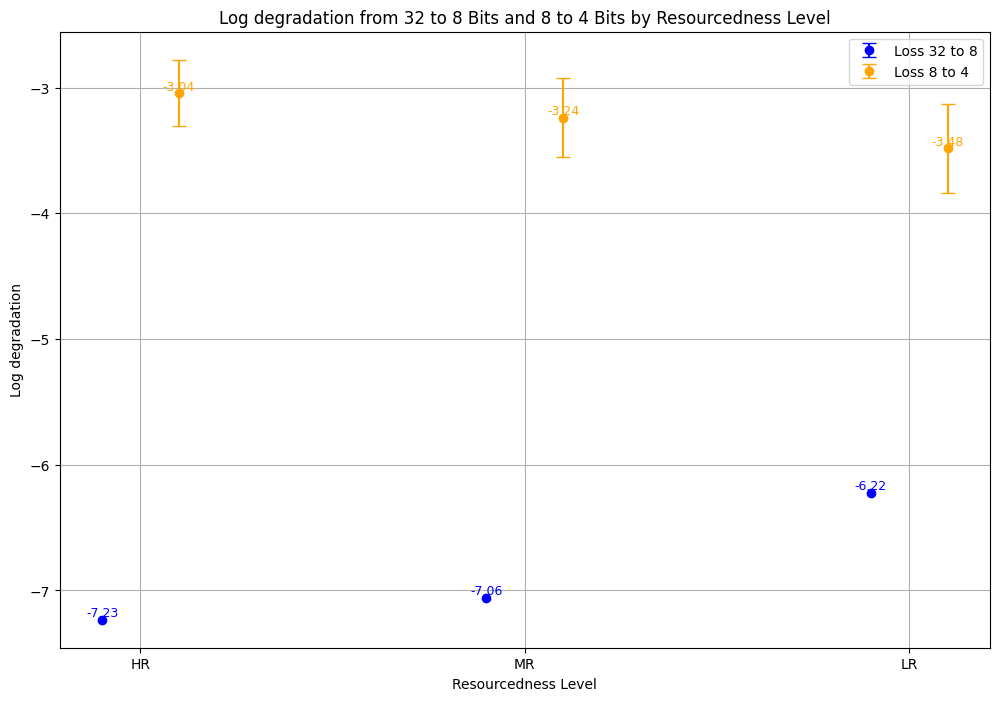

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_degradation(dataframe):
    # Calculate degradation from 32 to 8 and 8 to 4
    dataframe['Loss 32 to 8'] = dataframe['8 bits'] - dataframe['32 bits']
    dataframe['Loss 8 to 4'] = dataframe['4 bits'] - dataframe['8 bits']
    return dataframe

def combined_boxplot_with_ci(dataframe):
    # Create a new column in the dataframe to categorize languages into HR, MR, LR
    dataframe['Resourcedness'] = dataframe['Language'].map(language_resourcedness)

    # Drop rows with missing resourcedness labels (if any)
    dataframe = dataframe.dropna(subset=['Resourcedness'])

    # Prepare the plot
    plt.figure(figsize=(12, 8))

    # Loop over the resourcedness levels and plot degradation with CI
    for i, resourcedness_level in enumerate(['HR', 'MR', 'LR']):
        # Data for degradation 32 to 8
        data_32_to_8 = dataframe[dataframe['Resourcedness'] == resourcedness_level]['Log degradation 32-8']
        mean_32_to_8 = np.mean(data_32_to_8)
        ci_32_to_8 = stats.t.interval(0.95, len(data_32_to_8)-1, loc=mean_32_to_8, scale=stats.sem(data_32_to_8))

        # Data for degradation 8 to 4
        data_8_to_4 = dataframe[dataframe['Resourcedness'] == resourcedness_level]['Log degradation 8-4']
        mean_8_to_4 = np.mean(data_8_to_4)
        ci_8_to_4 = stats.t.interval(0.95, len(data_8_to_4)-1, loc=mean_8_to_4, scale=stats.sem(data_8_to_4))

        # Plotting
        plt.errorbar([i - 0.1], [mean_32_to_8], yerr=[[mean_32_to_8 - ci_32_to_8[0]], [ci_32_to_8[1] - mean_32_to_8]],
                     fmt='o', color='blue', capsize=5, label='Loss 32 to 8' if i == 0 else "")
        plt.errorbar([i + 0.1], [mean_8_to_4], yerr=[[mean_8_to_4 - ci_8_to_4[0]], [ci_8_to_4[1] - mean_8_to_4]],
                     fmt='o', color='orange', capsize=5, label='Loss 8 to 4' if i == 0 else "")

        # Annotate the means
        plt.text(i - 0.1, mean_32_to_8, f'{mean_32_to_8:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
        plt.text(i + 0.1, mean_8_to_4, f'{mean_8_to_4:.2f}', ha='center', va='bottom', fontsize=9, color='orange')
        print("32 bits to 8 ", ci_32_to_8)
        print("8 bits to 4 ", ci_8_to_4)
    # Set the x-ticks and labels
    plt.xticks(range(len(['HR', 'MR', 'LR'])), ['HR', 'MR', 'LR'])
    plt.xlabel('Resourcedness Level')
    plt.ylabel('Log degradation')

    # Title and legend
    plt.title('Log degradation from 32 to 8 Bits and 8 to 4 Bits by Resourcedness Level')
    plt.legend()
    plt.grid(True)

    # Show the plotS
    plt.show()

# Example usage with the data already loaded as 'quantization_results':
quantization_results = calculate_degradation(quantization_results)
combined_boxplot_with_ci(quantization_results)


In [ ]:
quantization_results

,Language,4 bits,8 bits,32 bits,Internet Fraction,Log Dataset Fraction,Fraction 4-32,Fraction 8-32,Fraction 32-4,Fraction 8-4,...,Log degradation 32-8,Log degradation 8-4,Log Fraction 4-32,Log Fraction 8-32,Diff 4-32,loss 32-4,log loss 32-4,Loss 32 to 8,Loss 8 to 4,Resourcedness
0,cy,108.187500,104.812500,104.462090,0.0100,-4.605170,1.035663,1.003354,0.965565,0.968804,...,-5.700823,-3.467471,0.035042,0.003349,3.725410,3.725410,1.315177,0.350410,3.375000,LR
1,mt,101.187500,98.500000,98.233383,0.0044,-5.426151,1.030072,1.002714,0.970806,0.973440,...,-5.911999,-3.628364,0.029629,0.002710,2.954117,2.954117,1.083200,0.266617,2.687500,LR
2,uz,101.625000,96.562500,96.667213,0.0240,-3.729701,1.051287,0.998917,0.951215,0.950185,...,NaN,-2.999429,0.050015,-0.001084,4.957787,4.957787,1.600959,-0.104713,5.062500,LR
3,ps,11.007812,10.812500,10.782387,0.0035,-5.654992,1.020907,1.002793,0.979521,0.982257,...,-5.883494,-4.031760,0.020691,0.002789,0.225426,0.225426,-1.489765,0.030113,0.195312,LR
4,si,4.203125,4.144531,4.153053,0.0087,-4.744432,1.012057,0.997948,0.988087,0.986059,...,NaN,-4.272956,0.011985,-0.002054,0.050072,0.050072,-2.994299,-0.008522,0.058594,LR
5,yo,13.460938,12.843750,12.794151,0.0009,-7.013116,1.052116,1.003877,0.950465,0.954150,...,-5.556648,-3.082374,0.050804,0.003869,0.666786,0.666786,-0.405286,0.049599,0.617188,LR
6,jv,89.312500,86.562500,86.467346,0.0020,-6.214608,1.032904,1.001100,0.968144,0.969209,...,-6.813127,-3.480541,0.032375,0.001100,2.845154,2.845154,1.045617,0.095154,2.750000,LR
7,ku,99.625000,94.312500,94.291267,0.0061,-5.099467,1.056567,1.000225,0.946462,0.946675,...,-8.398831,-2.931351,0.055025,0.000225,5.333733,5.333733,1.674051,0.021233,5.312500,LR
8,lo,4.078125,4.003906,4.006623,0.0037,-5.599422,1.017846,0.999322,0.982467,0.981801,...,NaN,-4.006376,0.017689,-0.000678,0.071502,0.071502,-2.638027,-0.002717,0.074219,LR
9,lb,159.250000,150.750000,149.997513,0.0035,-5.654992,1.061684,1.005017,0.941900,0.946625,...,-5.299994,-2.930409,0.059857,0.005004,9.252487,9.252487,2.224892,0.752487,8.500000,LR


HR | 32 bits to 8 bits: Mean = 0.0242, Std Dev = 0.0309
HR | 8 bits to 4 bits: Mean = 1.6512, Std Dev = 1.8348
MR | 32 bits to 8 bits: Mean = 0.1133, Std Dev = 0.1638
MR | 8 bits to 4 bits: Mean = 2.6783, Std Dev = 2.6877
LR | 32 bits to 8 bits: Mean = 0.1450, Std Dev = 0.2396
LR | 8 bits to 4 bits: Mean = 2.8633, Std Dev = 2.6594


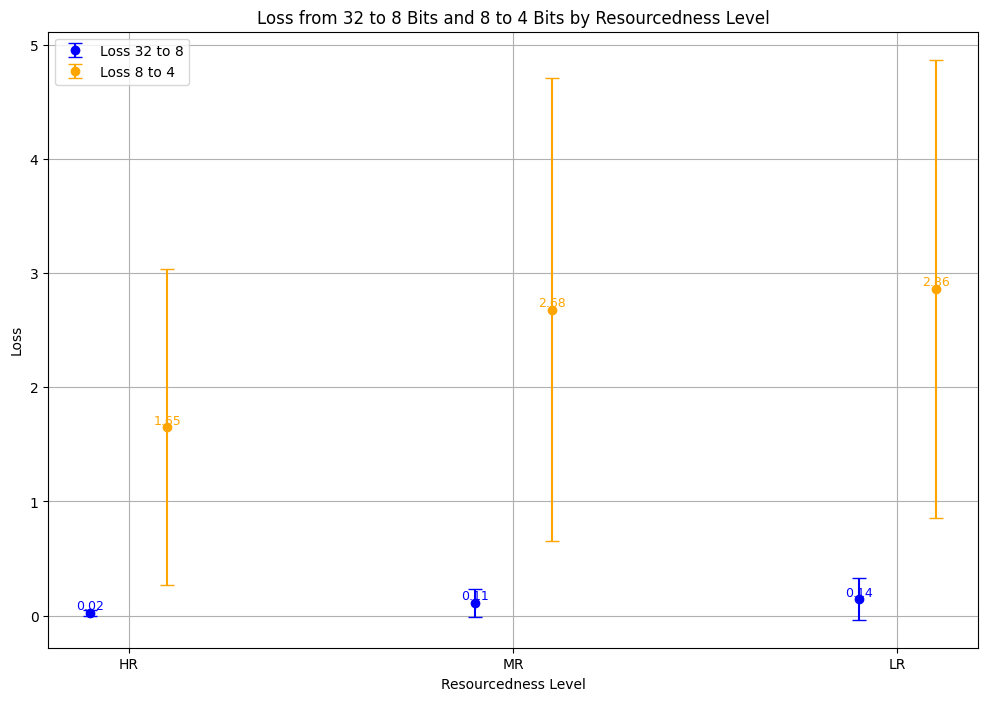

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_degradation(dataframe):
    # Calculate degradation from 32 to 8 and 8 to 4
    dataframe['Loss 32 to 8'] = dataframe['8 bits'] - dataframe['32 bits']
    dataframe['Loss 8 to 4'] = dataframe['4 bits'] - dataframe['8 bits']
    return dataframe

def combined_boxplot_with_ci(dataframe):
    # Create a new column in the dataframe to categorize languages into HR, MR, LR
    dataframe['Resourcedness'] = dataframe['Language'].map(language_resourcedness)

    # Drop rows with missing resourcedness labels (if any)
    dataframe = dataframe.dropna(subset=['Resourcedness'])

    # Prepare the plot
    plt.figure(figsize=(12, 8))

    # Arrays to hold mean values for connection
    means_32_to_8 = []
    means_8_to_4 = []

    # Loop over the resourcedness levels and plot degradation with CI
    for i, resourcedness_level in enumerate(['HR', 'MR', 'LR']):
        # Data for degradation 32 to 8
        data_32_to_8 = dataframe[dataframe['Resourcedness'] == resourcedness_level]['Loss 32 to 8']
        mean_32_to_8 = np.mean(data_32_to_8)
        std_32_to_8 = np.std(data_32_to_8)
        ci_32_to_8 = stats.t.interval(0.95, len(data_32_to_8)-1, loc=mean_32_to_8, scale=stats.sem(data_32_to_8))

        # Data for degradation 8 to 4
        data_8_to_4 = dataframe[dataframe['Resourcedness'] == resourcedness_level]['Loss 8 to 4']
        mean_8_to_4 = np.mean(data_8_to_4)
        std_8_to_4 = np.std(data_8_to_4)
        ci_8_to_4 = stats.t.interval(0.95, len(data_8_to_4)-1, loc=mean_8_to_4, scale=stats.sem(data_8_to_4))

        # Print mean and standard deviation
        print(f"{resourcedness_level} | 32 bits to 8 bits: Mean = {mean_32_to_8:.4f}, Std Dev = {std_32_to_8:.4f}")
        print(f"{resourcedness_level} | 8 bits to 4 bits: Mean = {mean_8_to_4:.4f}, Std Dev = {std_8_to_4:.4f}")

        # Append means to arrays for connection
        means_32_to_8.append(mean_32_to_8)
        means_8_to_4.append(mean_8_to_4)

        # Plotting
        plt.errorbar([i - 0.1], [mean_32_to_8], yerr=[[mean_32_to_8 - ci_32_to_8[0]], [ci_32_to_8[1] - mean_32_to_8]],
                     fmt='o', color='blue', capsize=5, label='Loss 32 to 8' if i == 0 else "")
        plt.errorbar([i + 0.1], [mean_8_to_4], yerr=[[mean_8_to_4 - ci_8_to_4[0]], [ci_8_to_4[1] - mean_8_to_4]],
                     fmt='o', color='orange', capsize=5, label='Loss 8 to 4' if i == 0 else "")

        # Annotate the means
        plt.text(i - 0.1, mean_32_to_8, f'{mean_32_to_8:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
        plt.text(i + 0.1, mean_8_to_4, f'{mean_8_to_4:.2f}', ha='center', va='bottom', fontsize=9, color='orange')

    # Set the x-ticks and labels
    plt.xticks(range(len(['HR', 'MR', 'LR'])), ['HR', 'MR', 'LR'])
    plt.xlabel('Resourcedness Level')
    plt.ylabel('Loss')

    # Title and legend
    plt.title('Loss from 32 to 8 Bits and 8 to 4 Bits by Resourcedness Level')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage with the data already loaded as 'quantization_results':
quantization_results = calculate_degradation(quantization_results)
combined_boxplot_with_ci(quantization_results)


# Lang stat

In [ ]:
quantization_results['Internet Fraction'] = quantization_results['Language'].map(language_internet_fraction)
quantization_results['Log Dataset Fraction'] = np.log(quantization_results['Internet Fraction'])
quantization_results['Resourcedness'] = quantization_results['Language'].map(language_resourcedness)

In [ ]:
quantization_results[['Language', 'Resourcedness', 'Internet Fraction', 'Log Dataset Fraction']].sort_values(by=['Internet Fraction'], ascending=False)

,Language,Resourcedness,Internet Fraction,Log Dataset Fraction
20,en,HR,43.7909,3.779426
25,ru,HR,6.1035,1.808862
22,de,HR,5.2890,1.665629
27,ja,HR,4.7980,1.568199
23,es,HR,4.5593,1.517169
21,fr,HR,4.2211,1.440096
29,pt,HR,2.1237,0.753160
24,nl,HR,1.8216,0.599715
17,id,MR,1.0426,0.041718
28,ko,HR,0.7032,-0.352114
